<font size="1">Copyright 2021, by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.</font>
    
<font size="1">This software may be subject to U.S. export control laws and regulations. By accepting this document, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required, before exporting such information to foreign countries or providing access to foreign persons.<font>

# Small baseline InSAR time series analysis with smallbaselineApp #

#### Kernel: mintpy

There are two groups of InSAR time series techniques: persistent scatterer (PS) methods, which focus on the phase-stable point scatterers, and distributed scatterer (DS) methods, which relaxed the strict limit on the phase stability and included areas that are affected by decorrelation through the exploitation of the redundant network of interferograms. In this notebook we focus on the DS method, and more specifically, the DS method with the network of small baseline interferograms (SBAS) using smallbaselineApp.py

The detailed algorithms and mathematical formulations implemented in MintPy software can be found in the literature:

+ Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331, doi:[10.1016/j.cageo.2019.104331](https://doi.org/10.1016/j.cageo.2019.104331), [arXiv](https://eartharxiv.org/9sz6m/).

# smallbaselineApp (general overview) #

smallbaselineApp.py is a MintPy script for the routine processing workflow of InSAR time series analysis. The script takes a stack of coregistered and unwrapped interferograms and generates the displacement time-series. The workflow consists of two main blocks:   
+ correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),   
+ correcting for noise from different sources to obtain the displacement time-series (green ovals).    

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through the various steps.      
     
<p align="left">
  <img width="600" src="support_docs/smallbaselineApp/smallbaselineApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

The input is a stack of **phase-unwrapped** interferograms **coregistered to a common SAR acquisition**, corrected for earth curvature and topography, which are referred hereafter as a **InSAR stack**. MintPy currently supports InSAR stacks produced by ISCE, GAMMA and ROI_PAC software (Rosen et al., 2004; 2012; Werner et al., 2000) with example data directories shown [here](https://mintpy.readthedocs.io/en/latest/dir_structure/).

### Example dataset ###
Here we use the InSAR stack from Sentinel-1 satellite descending track 128 acquired over Fernandina volcano, Galapagos, Ecuador as an example ([Zenodo](https://zenodo.org/record/3635245); ~750M in size). It spans from 2014-12-13 to 2018-06-19 with 98 acquisitions in total. We use the stack Sentinel processor (Fattahi et al., 2016) within ISCE (Rosen et al., 2012) for processing the InSAR stack.     

<p align="left">
  <img src="support_docs/smallbaselineApp/FernandinaSenDT128_unwrapPhase_wrap.png">
</p>

## 0. Initial setup of the notebook ##

The cell below performs the intial setup of the notebook and **must be run every time the notebook (re)starts**. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mintpy.objects import ifgramStack
from mintpy.utils import plot as pp, utils as ut
from mintpy import view, plot_network

# this block makes sure the directory set-up/change is only done once and relative to the notebook's directory
try:
    start_dir
except NameError:
    start_dir = os.getcwd()

# define work directory
work_dir = os.path.join(start_dir, 'notebook_output/smallbaselineApp/data/test')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download example dataset
proj_name = 'FernandinaSenDT128'
tar_file = '{}.tar.xz'.format(proj_name)
if not os.path.isfile(tar_file):
    !wget https://zenodo.org/record/3635245/files/FernandinaSenDT128.tar.xz
else:
    print('{} exists.'.format(tar_file))

# uncompress example dataset
if not os.path.isdir(proj_name):
    cmd = 'tar -xJf FernandinaSenDT128.tar.xz'
    print('uncompressing the tar file:', cmd, '...')
    !{cmd}

# go to project directory
proj_dir = os.path.join(work_dir, '{}/mintpy'.format(proj_name))
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test
--2021-09-24 21:41:02--  https://zenodo.org/record/3635245/files/FernandinaSenDT128.tar.xz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 751548676 (717M) [application/octet-stream]
Saving to: ‘FernandinaSenDT128.tar.xz’

100%[======================================>] 751,548,676 4.88MB/s   in 3m 6s  

2021-09-24 21:44:10 (3.85 MB/s) - ‘FernandinaSenDT128.tar.xz’ saved [751548676/751548676]

uncompressing the tar file: tar -xJf FernandinaSenDT128.tar.xz ...
Go to project directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy


## 1. Setting up template file ##

The configuration parameters to smallbaselineApp.py are controlled through two template files. At least one template is required to run smallbaselineApp.py.    

+ `default template`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). It contains all configuration parameters, grouped by steps, with default _auto_ values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.


+ `custom template` (optional but recommended): FernandinaSenDT128.txt in the example dataset. It constains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the default template; if custom template is input, smallbaselineApp.py will update the default smallbaselineApp.cfg file accordingly.       

### Custom template example ###

The path of all input files (`mintpy.load.*`) and the reference point (`mintpy.reference.*`) are always recommended. Below are from FernandinaSenDT128.txt file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = ../master/IW*.xml
mintpy.load.baselineDir      = ../baselines
##---------interferogram datasets:
mintpy.load.unwFile          = ../merged/interferograms/*/filt_*.unw
mintpy.load.corFile          = ../merged/interferograms/*/filt_*.cor
mintpy.load.connCompFile     = ../merged/interferograms/*/filt_*.unw.conncomp
##---------geometry datasets:
mintpy.load.demFile          = ../merged/geom_master/hgt.rdr
mintpy.load.lookupYFile      = ../merged/geom_master/lat.rdr
mintpy.load.lookupXFile      = ../merged/geom_master/lon.rdr
mintpy.load.incAngleFile     = ../merged/geom_master/los.rdr
mintpy.load.azAngleFile      = ../merged/geom_master/los.rdr
mintpy.load.shadowMaskFile   = ../merged/geom_master/shadowMask.rdr
mintpy.load.waterMaskFile    = None

mintpy.reference.lalo        = -0.30,-91.43
mintpy.topographicResidual.stepFuncDate  = 20170910,20180613  #eruption dates
mintpy.deramp                = linear
```
    
Check **more examples for custom template** on [here](https://github.com/insarlab/MintPy/tree/master/docs/examples/input_files).      
Run **load_data.py -H** for example input file paths for GAMMA and ROI_PAC.   

## 2. smallbaselineApp.py processing steps ##

The smallbaselineApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. More detailed usage can be found in help. 

In [2]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

### 2.1 Load the InSAR stack ###

This step prepares the required metadata (using prep_isce/gamma/roipac.py commands internally) and load all data files and their metadata into HDF5 files in the **./inputs** folder, including:
```cfg
./inputs/ifgramStack.h5
./inputs/geometryRadar.h5
./inputs/geometryGeo.h5 #for geocoded dataset or GAMMA/ROIPAC dataset in radar coordinates
```

The corresponding template options are:
```cfg
########## 1. load_data
## a. auto - automatic path pattern for Univ of Miami file structure
## b. load_data.py -H to check more details and example inputs.
## c. compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]
mintpy.load.processor      = auto  #[isce, aria, snap, gamma, roipac], auto for isce
mintpy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------for ISCE only:
mintpy.load.metaFile       = auto  #[path of common metadata file for the stack], i.e.: ./master/IW1.xml, ./masterShelve/data.dat
mintpy.load.baselineDir    = auto  #[path of the baseline dir], i.e.: ./baselines
##---------interferogram datasets:
mintpy.load.unwFile        = auto  #[path pattern of unwrapped interferogram files]
mintpy.load.corFile        = auto  #[path pattern of spatial coherence       files]
mintpy.load.connCompFile   = auto  #[path pattern of connected components    files], optional
mintpy.load.intFile        = auto  #[path pattern of wrapped interferogram   files], optional
mintpy.load.ionoFile       = auto  #[path pattern of ionospheric delay       files], optional
##---------offset datasets (optional):
mintpy.load.azOffFile      = auto  #[path pattern of azimuth offset file], optional
mintpy.load.rgOffFile      = auto  #[path pattern of range   offset file], optional
mintpy.load.offSnrFile     = auto  #[path pattern of offset signal-to-noise ratio file], optional
##---------geometry datasets:
mintpy.load.demFile        = auto  #[path of DEM file]
mintpy.load.lookupYFile    = auto  #[path of latitude /row   /y coordinate file], not required for geocoded data
mintpy.load.lookupXFile    = auto  #[path of longitude/column/x coordinate file], not required for geocoded data
mintpy.load.incAngleFile   = auto  #[path of incidence angle file], optional
mintpy.load.azAngleFile    = auto  #[path of azimuth   angle file], optional
mintpy.load.shadowMaskFile = auto  #[path of shadow mask file], optional
mintpy.load.waterMaskFile  = auto  #[path of water  mask file], optional
mintpy.load.bperpFile      = auto  #[path pattern of 2D perpendicular baseline file], optional
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
mintpy.subset.yx   = auto    #[1800:2000,700:800 / no], auto for no
mintpy.subset.lalo = auto    #[31.5:32.5,130.5:131.0 / no], auto for no
```

In [3]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep load_data

MintPy release version v1.3.1, release date 2021-08-02
--RUN-at-2021-09-24 21:45:37.279888--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
copy default template file /home/jovyan/.local/envs/mintpy/lib/python3.8/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /home/jovyan/nisar-on-demand-use-cases/no

Go back to directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 13.4 secs



In [4]:
!ls -l inputs                      #check loaded files in ./INPUTS directory

total 751532
-rw-r--r-- 1 jovyan users 109286312 Feb  4  2020 ERA5.h5
-rw-r--r-- 1 jovyan users      1835 May 11  2019 FernandinaSenDT128.txt
-rw-r--r-- 1 jovyan users   4132980 Sep 24 21:45 geometryRadar.h5
-rw-r--r-- 1 jovyan users 656106431 Sep 24 21:45 ifgramStack.h5
-rw-r--r-- 1 jovyan users     20952 Sep 24 21:45 smallbaselineApp.cfg


#### ./inputs/ifgramStack.h5 ####

The ./inputs/ifgramStack.h5 file contains all unwrapped phase, spatial coherence, connected components (generated by SNAPHU) and the auxiliary data including the perpendicular baseline and dates for each interferogram.

In [5]:
!info.py inputs/ifgramStack.h5     #use info.py / gdalinfo to check the HDF5 file information

/bin/bash: info.py: command not found


run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is ifgramStack file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (450, 600)
input dataset: "['20180315_20180327']"
num of datasets in file ifgramStack.h5: 864
num of datasets to exclude: 0
num of datasets to display: 3
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: unwrapPhase
figure size : [15.00, 8.00]
dataset number: 3
row     number: 1
column  number: 3
figure  number: 1
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 - unwrapPhase.png
reading data as a list of 2D matrices ...
[==

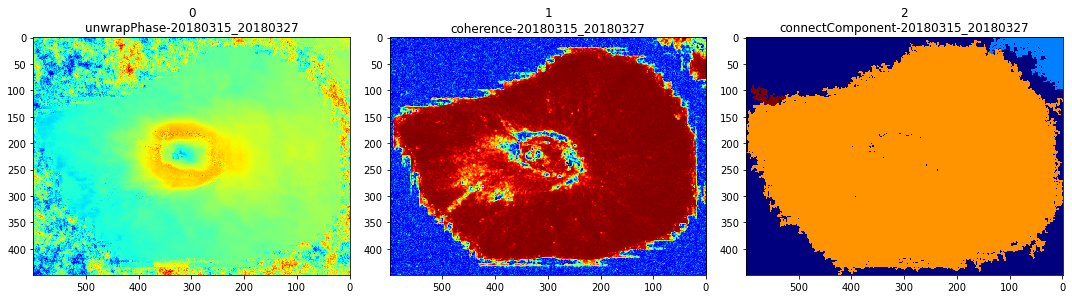

In [7]:
# plot all data related with one interferometric pair
view.main('./inputs/ifgramStack.h5 20180315_20180327 --ncols 3'.split())

#### ./inputs/geometry*.h5 ####

The ./inputs/geometryRadar.h5 file contains all geometry related data, including height, latitude, longitude, incidence angle, etc. If these files are in geo coordinates, then the output file will be geometryGeo.h5.

Note that for **ISCE**, the lookup files (`lat.rdr and lon.rdr`) are in radar coordinates and are loaded into ./inputs/geometryRadar.h5 file as "latitude" and "longitude" dataset; while **GAMMA and ROI_PAC** lookup files (`sim*.UTM_TO_RDC and geomap*.trans`) are in geo coordinates and are loaded into ./inputs/geometryGeo.h5 file as "azimuthCoord" and "rangeCoord" dataset.

In [8]:
!info.py ./inputs/geometryRadar.h5 --compact

******************** Basic File Info ************************
file name: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/inputs/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                     5
  ANTENNA_SIDE                               -1
  AZIMUTH_PIXEL_SIZE                         78.08212603857966
  CENTER_LINE_UTC                            42584.0
  DATA_TYPE                                  float64
  EARTH_RADIUS                               6337286.638938101
  FILE_LENGTH                                450
  FILE_PATH                                  /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/merged/geom_master/hgt.rdr
  FILE_TYPE                                  geometry
  HEADING                                    -168.01821899414062
 

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is geometry file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/inputs/geometryRadar.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file geometryRadar.h5: 7
datasets to exclude (0):
[]
datasets to display (7):
['height', 'latitude', 'longitude', 'incidenceAngle', 'azimuthAngle', 'slantRangeDistance', 'shadowMask']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: geometryRadar
figure size : [15.00, 8.00]
dataset number: 7
row     number: 2
column  number: 4
figure  number: 1
----------------------------------------
Figure 1 - geometryRadar.png
reading data as a list of 2D matrices ...
[====

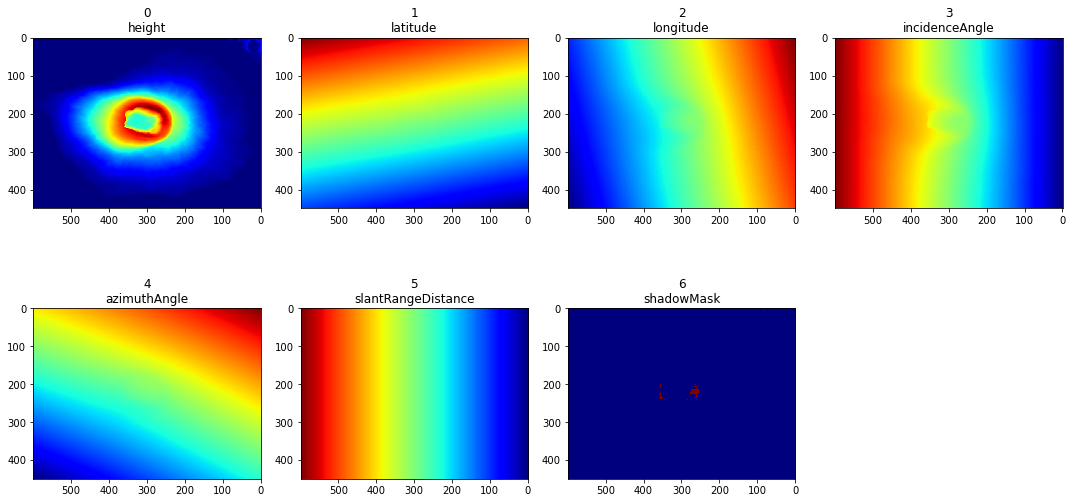

In [9]:
view.main('./inputs/geometryRadar.h5'.split())

### 2.2 Network modification (optional) ###

This step identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion. This is done by setting the corresponding dataset `dropIfgram = False` in ./inputs/ifgramStack.h5 file. The corresponding template options are:

```cfg
########## 2. modify_network
## reference: Yunjun et al. (2019, section 4.2 and 5.3.1)
## 1) Coherence-based network modification = (threshold + MST) by default
## It calculates a average coherence value for each interferogram using spatial coherence and input mask
## Then it finds a minimum spanning tree (MST) network with inverse of average coherence as weight
## For all interferograms except for MST's, exclude those with average coherence < minCoherence.
mintpy.network.coherenceBased  = auto  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.keepMinSpanTree = auto  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
mintpy.network.minCoherence    = auto  #[0.0-1.0], auto for 0.7
mintpy.network.maskFile        = auto  #[file name, no], auto for waterMask.h5 or no [if no waterMask.h5 found]
mintpy.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
mintpy.network.aoiLALO         = auto  #[lat0:lat1,lon0:lon1 / no], auto for no - use the whole area

## 2) Network modification based on temporal/perpendicular baselines, date etc.
mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, max perpendicular spatial baseline in m
mintpy.network.connNumMax      = auto  #[1-inf, no], auto for no, max number of neighbors for each acquisition
mintpy.network.startDate       = auto  #[20090101 / no], auto for no
mintpy.network.endDate         = auto  #[20110101 / no], auto for no
mintpy.network.excludeDate     = auto  #[20080520,20090817 / no], auto for no
mintpy.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
mintpy.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no
```

<div class="alert alert-info">
<b>TIP:</b> 
For coherence-based network modification, a customized area of interest (AOI) that includes the low coherent areas surrounding the areas with coherent phase-unwrapping error is highly recommended. Such as the blue rectangle in the figure below.
</div>

<p align="center">
  <img width=600, src="support_docs/smallbaselineApp/net_modification.jpg">
</p>    
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>    

In this dataset, we turn off (by default) this option and skip this step, becuase there is no remaining phase-unwrapping error on coherent pixels.

In [10]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep modify_network

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:21:55.889277--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value fo

#### Plot network ####

The network configuration information is plotted and saved into the following files:

+ Network.pdf: network configuration in temporal and perpendicular baseline plane.
+ CoherenceMatrix.pdf: average spatial coherence of each interferogram.
+ CoherenceHistory.pdf: the min/max average spatial coherence of all interferograms for each acquisition.
+ BperpHistory.pdf: the perpendicular spatial baseline history of the dataset.

The network configuartion and coherence matrix is re-plotted in the cell below:

read temporal/spatial baseline info from file: ./inputs/ifgramStack.h5
calculating spatial mean of coherence in file ./inputs/ifgramStack.h5 ...
read mask from file: waterMask.h5
[==================================================] 288/288    1s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 98
number of interferograms: 288
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 288
number of acquisitions marked as drop: 0
max perpendicular baseline: 214.31 m
max temporal      baseline: 96.0 days
showing coherence
data range: [0.9150893, 0.9917158]
display range: (0.2, 1.0)
showing ...


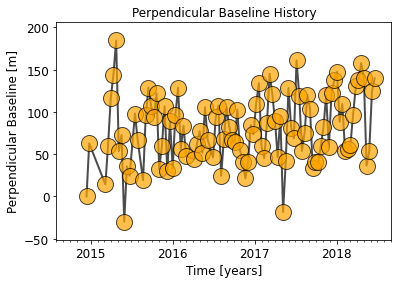

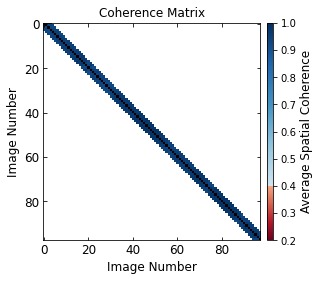

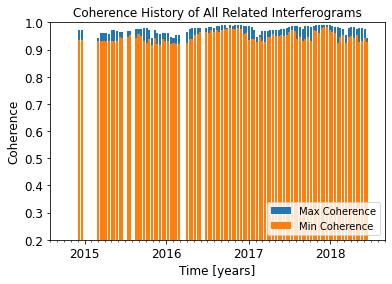

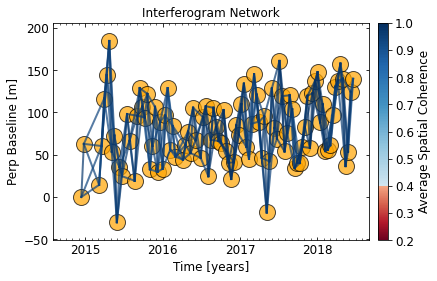

In [11]:
plot_network.main(['./inputs/ifgramStack.h5'])

### 2.3 Select reference point ###

This step adds the reference point information into the **./inputs/ifgramStack.h5** by adding the metadata **REF_Y/X** (and REF_LAT/LON if input dataset is geocoded). The reference point should have valid phase (not NaN or zero) in all interferograms.    

The reference pixel can be selected in two ways:
1. randomly among the pixels with high average spatial coherence (default threshold is 0.85).
2. specified using prior knowledge of the study area `(recommended)`. The reference pixel should be:
   1. located in a coherent area;
   2. not be affected by strong atmospheric turbulence such as ionospheric streaks; 
   3. close to and with similar elevation as the area of interest to minimize the impact of the spatially correlated atmospheric delay. For example, Chaussard et al. (2013) and Morales-Rivera et al. (2016) studied volcano deformation using reference points on inactive, neighboring volcanoes.  
   
The corresponding template options are:

```cfg
## reference all interferograms to one common point in space
## auto - randomly select a pixel with coherence > minCoherence
mintpy.reference.yx            = auto   #[257,151 / auto]
mintpy.reference.lalo          = auto   #[31.8,130.8 / auto]
mintpy.reference.maskFile      = auto   #[filename / no], auto for maskConnComp.h5
mintpy.reference.coherenceFile = auto   #[filename], auto for avgSpatialCoh.h5
mintpy.reference.minCoherence  = auto   #[0.0-1.0], auto for 0.85, minimum coherence for auto method
```
   
This step also generates the following auxiliary files:
+ avgSpatialCoh.h5: the average spatial coherence among all interferograms.
+ maskSpatialCoh.h5 : mask file from the average spatial coherence with min value of 0.7
+ maskConnComp.h5: the common connected components among all interferograms.

In [12]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep reference_point

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:23:19.288850--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating

In [13]:
!ls -l

total 1708
-rw-r--r-- 1 jovyan users 1109560 Feb 24 19:23 avgSpatialCoh.h5
-rw-r--r-- 1 jovyan users   13547 Feb 24 19:23 coherenceSpatialAvg.txt
-rw-r--r-- 1 jovyan users    1835 May 11  2019 FernandinaSenDT128.txt
drwxr-sr-x 2 jovyan users    4096 Feb 24 19:21 inputs
-rw-r--r-- 1 jovyan users  288744 Feb 24 19:23 maskConnComp.h5
drwxr-sr-x 2 jovyan users    4096 Feb 24 19:21 pic
-rwxr-xr-x 1 jovyan users    5955 Dec 10 19:16 plot_smallbaselineApp.sh
-rw-r--r-- 1 jovyan users   18717 Feb 24 19:21 smallbaselineApp.cfg
-rw-r--r-- 1 jovyan users  287920 Feb  6  2019 waterMask.h5


In [14]:
!info.py ./inputs/ifgramStack.h5 | egrep 'REF_'    #attribute related to the reference point

  REF_X                                      156
  REF_Y                                      76


### 2.4 Quick overview ###

This step generates the following two files:

+ avgPhaseVelocity.h5: the average phase velocity using traditional stacking technique (Zebker et al., 1997) by dividing the unwrapped interferometric phase by their temporal baselines and averaging all interferograms. It provides a **quick assessment** of possible ground deformation.

+ numNonzeroIntClosure.h5: the number of interferogram triplets with non-zero integer ambiguity of the closure phase (section 3.2 in Yunjun et al., 2019). It provides a distribution map (pixels with non-zero values) of phase unwrapping errors.

In [15]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep quick_overview

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:23:45.377643--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is velocity file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/avgPhaseVelocity.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file avgPhaseVelocity.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: avgPhaseVelocity
figure size : [10.00, 6.00]
reading data ...
data    range: [-7.713094, 13.292522] cm/year
display range: [-7.713094, 13.292522] cm/year
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting Data ...
plot reference point
flip figure left and right
showing ...


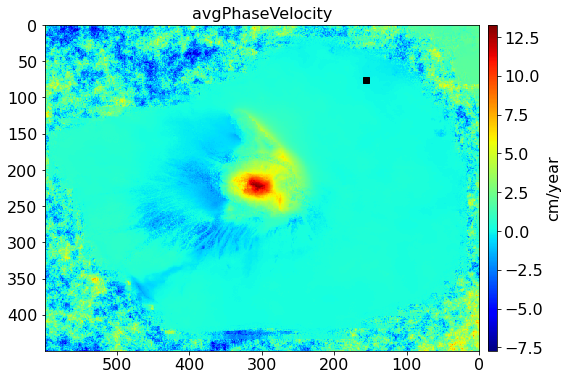

In [16]:
view.main('avgPhaseVelocity.h5'.split())     # plot the stacking result

plot and save figure to file numTriNonzeroIntAmbiguity.png


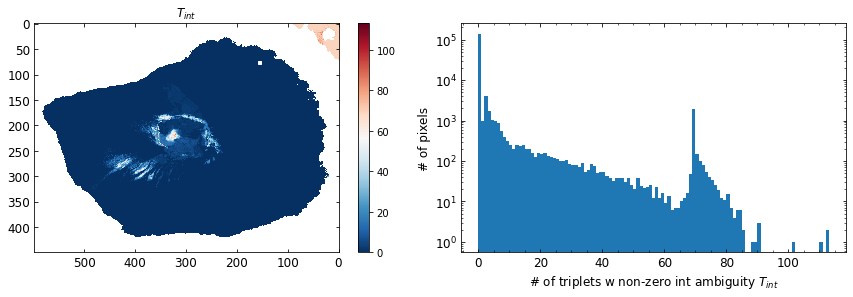

In [17]:
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[12, 4])

### 2.5 Phase-unwrapping error correction (optional) ###

This step corrects phase-unwrapping errors in the stack of interferograms, supporting the following methods (Yunjun et al., 2019):   
+ bridging
+ phase_closure
+ bridging+phase_closure    
    
If turn on, it will add new dataset named as "unwrapPhase_bridging" or "unwrapPhase_phaseClosure" or "unwrapPhase_bridging_phaseClosure" into the ./inputs/ifgramStack.h5 file. The corresonding template options are:

```cfg
########## 4. correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure           - suitable for highly redundant network
## b. bridging                - suitable for islands or areas with steep topography
## c. bridging+phase_closure  - recommended
mintpy.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if no waterMask.h5 found]

## briding options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##        before estimating the phase difference between reliable regions and added back the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
```

In this dataset, we turn off (by default) this option and skip this step.

### 2.6 Network inversion ###

This step inverts the network of interferograms for the raw phase time-series. Note that this raw phase time-series includes contributions from ground deformation, atmospheric delay and topographic residual caused by DEM error. The following **weighted least squares (WLS) inversions** methods are supported:

+ Inverse of covariance
+ Finisher Information Matrix (FIM)
+ Spatial coherence
+ Uniform / no weighting

The corresponding template options are:   

```cfg
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## c. coh - use coherence as weight (Perissin & Wang, 2012)
## d. no  - uniform weight (Berardino et al., 2002) [fast]
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
mintpy.networkInversion.weightFunc      = auto #[var / fim / coh / no], auto for var
mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity / phase
mintpy.networkInversion.residualNorm    = auto #[L2 ], auto for L2, norm minimization solution

## mask options for unwrapPhase of each interferogram before inversion (recommed if weightFunct=no):
## a. coherence        - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent - mask out pixels with False/0 value
## c. no               - no masking [recommended].
## d. offsetSNR        - mask out pixels with offset SNR < maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / offsetSNR / no], auto for no
mintpy.networkInversion.maskThreshold = auto #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

## Parallel processing with Dask
## Notes for "local" cluster:
## 1) no job scheduler is required to install on the cluster
## 2) no walltime or config is required to set
## 3) "numWorker = all" is for local cluster only, to use all local available resources.
mintpy.networkInversion.parallel  = auto #[yes / no], auto for no, parallel processing using dask
mintpy.networkInversion.cluster   = auto #[slurm / pbs / lsf / local], auto for local, cluster type
mintpy.networkInversion.config    = auto #[slurm / pbs / lsf / no], auto for no (same as cluster), config name
mintpy.networkInversion.numWorker = auto #[int > 1 / all], auto for 4 (local) or 40 (non-local), num of workers
mintpy.networkInversion.walltime  = auto #[HH:MM], auto for 00:40, walltime for each dask worker

## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = auto #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = auto #[yes / no], auto for yes [if shadowMask is in geometry file] or no.
```

It outputs the following files:   

```cfg
timeseries.h5         #raw phase time-series in unit of meters.
temporalCoherence.h5  #temporal coherence (Pepe et al., 2006).
maskTempCoh.h5        #mask of reliable pixels with min temporal coherence of "minTempCoh" value.
numInvIfgram.h5       #number of interferograms used in the inversion for each pixel.
                      #This number varies for different pixels if "maskDataset" is not "no".
```

In [18]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep invert_network

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:24:14.089789--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/small

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is timeseries file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/timeseries.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-20160113', 'timeseri

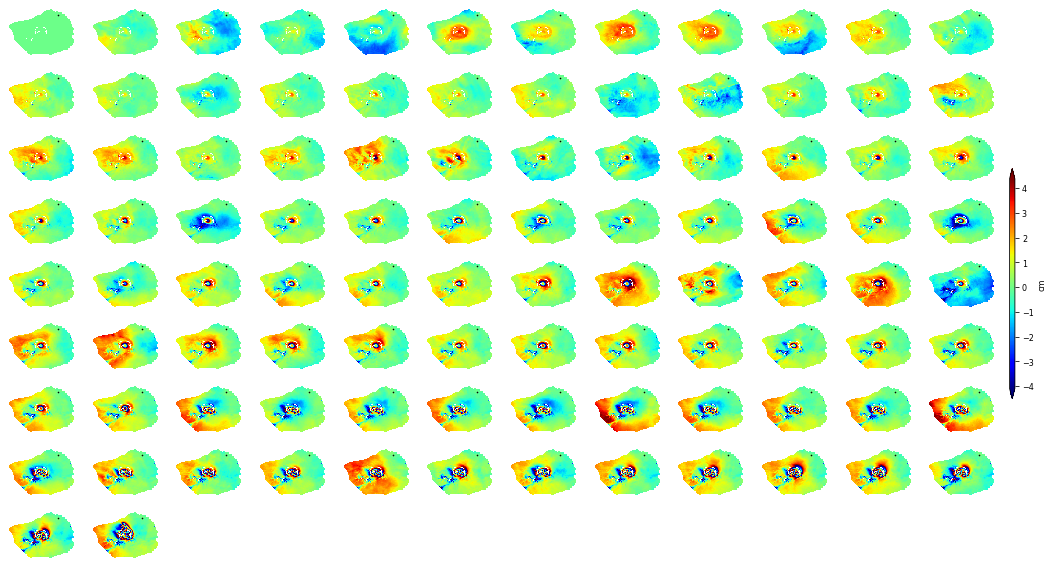

In [19]:
#plot the raw phase time-series and re-wrapped into [-5, 5) cm
view.main('timeseries.h5 --wrap --wrap-range -5 5 -u cm --notitle --notick --noaxis'.split())

Wed Feb 24 19:29:32 UTC 2021


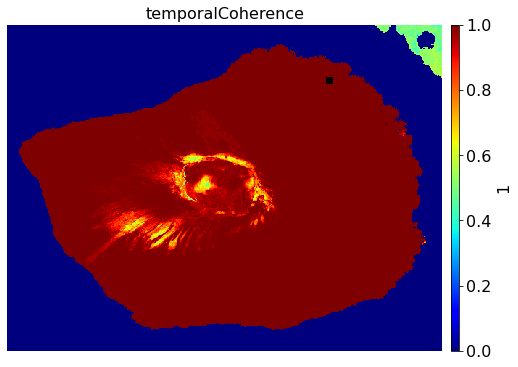

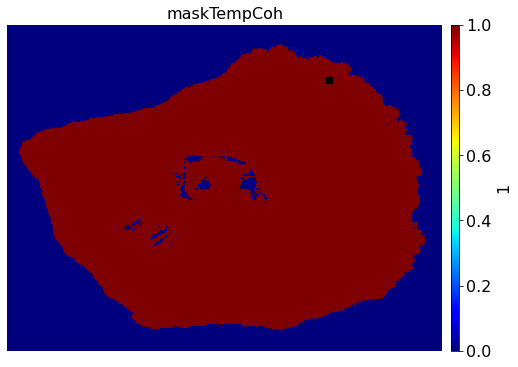

Wed Feb 24 19:29:34 UTC 2021


In [20]:
!date
view.main('temporalCoherence.h5 --notick --noaxis --noverbose'.split())
view.main('maskTempCoh.h5 --notick --noaxis --noverbose'.split())
!date

### 2.7 Correct local oscillator drift (for Envisat) ###

Data from Envisat’s Advanced Synthetic Aperture Radar (ASAR) instrument include a phase ramp in range direction due to timing errors. This step corrects the local oscillator drift using the empirical model given by Marinkovic and Larsen (2013). It's automatically turned ON for Envisat data and OFF for all the other dataset.

In [21]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep correct_LOD

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:29:39.821623--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_LOD']
Remaining steps: ['correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/t

### 2.8 Tropospheric delay correction ###

This step corrects the tropospheric phase delay. Two methods are supported:

+ Global Atmospheric Models (GAMs) (Jolivet et al., 2011; 2014; PyAPS needs to be installed).
+ Empirical relationship between stratified tropospheric delay and topography (Doin et al., 2009).

The corresponding template options are:

```cfg
## correct tropospheric delay using the following methods:
## a. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
## b. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
##      ERA5  - ERA-5       from ECMWF [need to install pyaps3 on GitHub; recommended and turn ON by default]
##      ECMWF - ERA-Interim from ECMWF [need to install pyaps  on Caltech/EarthDef]
##      MERRA - MERRA-2     from NASA  [need to install pyaps  on Caltech/EarthDef]
##      NARR  - NARR        from NOAA  [need to install pyaps  on Caltech/EarthDef; recommended for N America]
mintpy.troposphericDelay.method = auto  #[pyaps / height_correlation / no], auto for pyaps

## Notes for pyaps:
## a. GAM data latency: with the most recent SAR data, there will be GAM data missing, the correction
##    will be applied to dates with GAM data available and skipped for the others.
## b. WEATHER_DIR: if you define an environmental variable named WEATHER_DIR to contain the path to a
##    directory, then MintPy applications will download the GAM files into the indicated directory. 
##    MintPy application will look for the GAM files in the directory before downloading a new one to
##    prevent downloading multiple copies if you work with different dataset that cover the same date/time.
mintpy.troposphericDelay.weatherModel = auto  #[ERA5 / ECMWF / MERRA / NARR], auto for ERA5
mintpy.troposphericDelay.weatherDir   = auto  #[path2directory], auto for WEATHER_DIR or "./"

## Notes for height_correlation:
## Extra multilooking is applied to estimate the empirical phase/elevation ratio ONLY.
## For an dataset with 5 by 15 looks, looks=8 will generate phase with (5*8) by (15*8) looks
## to estimate the empirical parameter; then apply the correction to original phase (with 5 by 15 looks),
## if the phase/elevation correlation is larger than minCorrelation.
mintpy.troposphericDelay.polyOrder      = auto  #[1 / 2 / 3], auto for 1
mintpy.troposphericDelay.looks          = auto  #[1-inf], auto for 8, extra multilooking num
mintpy.troposphericDelay.minCorrelation = auto  #[0.0-1.0], auto for 0
```

It outputs:
+ timeseries_ECMWF.h5: the troposphere-corrected time-series (ECMWF data is selected in this case).
+ ECMWF.h5: the estimated tropospheric phase delay time-series (for pyaps method only).

In [22]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep correct_troposphere

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:29:47.210897--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_troposphere']
Remaining steps: ['deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaS

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is timeseries file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/timeseries_ERA5.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries_ERA5.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-20160113',

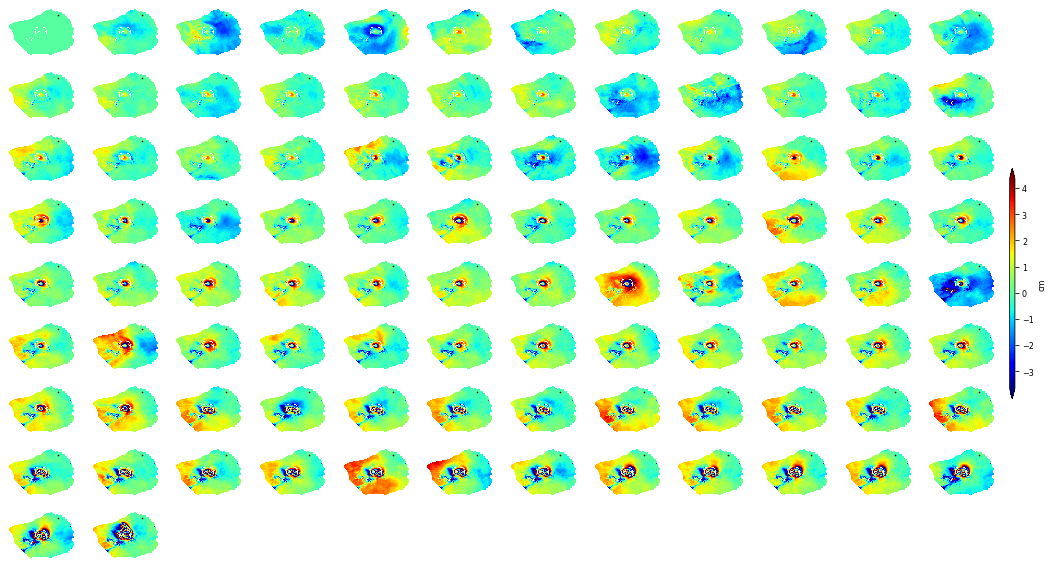

In [23]:
view.main('timeseries_ERA5.h5 --notitle --wrap --wrap-range -5 5 --notick --noaxis'.split())

### 2.9 Phase deramping (optional) ###

This step estimate and remove a linear or quadratic ramp for each acquisition based on the phase of the reliable pixels. It's recommended for localized deformation signals, such as volcanic deformation, landslides and city subsidence; but not recommeded for long spatial wavelength deformation signals, such as interseismic deformation.

The cooresponding template options are:

```cfg
## estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## recommended for localized deformation signals, i.e. volcanic deformation, landslide and subsidence, etc.
mintpy.deramp          = auto  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation
```

It outputs a new time-series HDF5 file with suffix _ramp_: timeseries_ECMWF_ramp.h5 in this example case.

In [24]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep deramp

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:30:01.360724--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbas

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is timeseries file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/timeseries_ERA5_ramp.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries_ERA5_ramp.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-

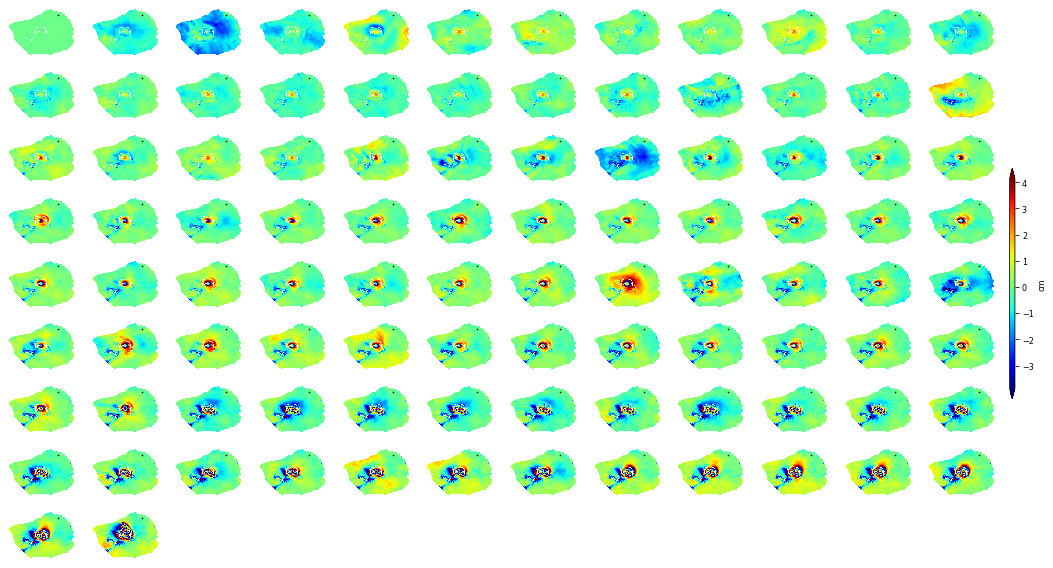

In [25]:
view.main('timeseries_ERA5_ramp.h5 --notitle --wrap --wrap-range -5 5 --notick --noaxis'.split())

### 2.10 Topographic residual (DEM error) correction ###

This step corrects the phase residual caused by the inaccuracy of DEM (DEM error) using its relationship with the perpendicular baseline time-series (Fattahi and Amelung, 2013, IEEE-TGRS). The corresponding template options are:

```cfg
## reference: Fattahi and Amelung, 2013, IEEE-TGRS
## Notes on options:
## stepFuncDate      - Specify stepFuncDate option if you know there are sudden displacement jump in your area,
##    i.e. volcanic eruption, or earthquake, and check timeseriesStepModel.h5 afterward for their estimation.
## excludeDate       - Dates excluded for error estimation only
## pixelwiseGeometry - Use pixel-wise geometry info, such as incidence angle and slant range distance for error estimation
##    yes - use pixel-wise geometry when they are available [slow; used by default]
##    no  - use mean geometry [fast]
mintpy.topographicResidual                    = auto  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder          = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity      = auto  #[yes / no], auto for no - phase, use phase velocity for error estimation
mintpy.topographicResidual.stepFuncDate       = auto  #[20080529,20100611 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate        = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry  = auto  #[yes / no], auto for yes, use pixel-wise geometry info
```

It outputs:
+ timeseries_ECMWF_ramp_demErr.h5: the topographic residual corrected time-series.
+ timeseriesResidual.h5: residual phase time-series of this least square inversion.
+ demErr.h5: the estimated DEM error.

In [26]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep correct_topography

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:30:15.806234--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.c

run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is timeseries file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101'

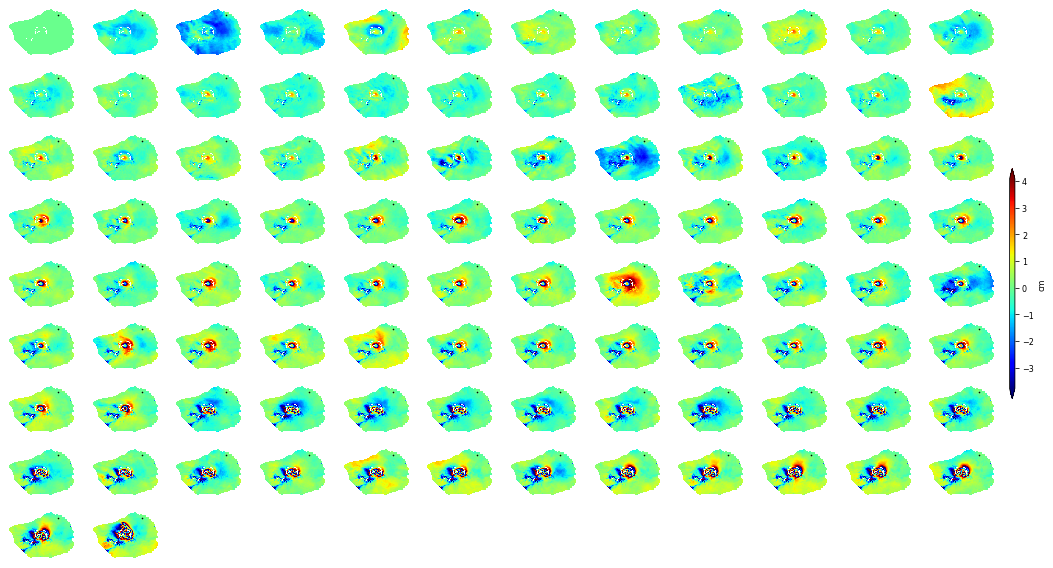

In [27]:
view.main('timeseries_ERA5_ramp_demErr.h5 --notitle --wrap --wrap-range -5 5 --notick --noaxis'.split())

### 2.11 Phase residual RMS for noise evaluation ###

This step calculates the Root Mean Square (RMS) of the residual phase time-series for each acquisition; then it:
1. selects the date with the minimum RMS value as the optimal reference date.
2. detects the noisy acquisitions with RMS beyond the outlier detection threshold.

The corresponding template options are:
```cfg
## 1) Residual Phase Root Mean Square
## calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## To get rid of long wavelength component in space, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3
```

It outputs:
+ rms_timeseriesResidual_ramp.txt: for RMS value of each acquisition
+ rms_timeseriesResidual_ramp.pdf: plot of the rms_timeseriesResidual_ramp.txt
+ reference_date.txt: date in YYYYMMDD format for the optional reference date
+ exclude_date.txt: date(s) in YYYYMMDD format for the noisy acquisitions (if at least one is detected).

In [28]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep residual_RMS

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:33:42.168788--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.cfg
read default templa

In [29]:
!head rms_timeseriesResidual_ramp.txt

# Root Mean Square in space for each acquisition of time-series
# Timeseries file: timeseriesResidual_ramp.h5
# Mask file: maskTempCoh.h5
# Date		RMS (m)
20141213	0.004895225632935762
20141225	0.0036000534892082214
20150307	0.012712251394987106
20150319	0.0034545499365776777
20150331	0.006172469817101955
20150412	0.0025237039662897587


In [30]:
!cat reference_date.txt    #auto selected optimal reference date.

20180619


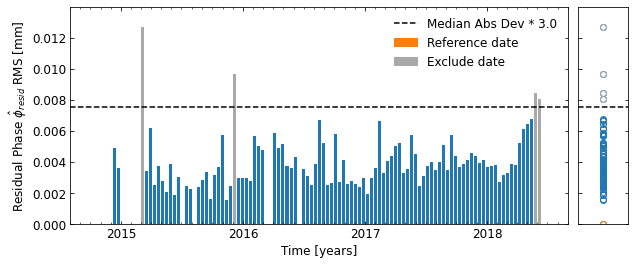

In [31]:
## plot the RMS value
from mintpy.timeseries_rms import plot_rms_bar
txtContent = np.loadtxt('./rms_timeseriesResidual_ramp.txt', dtype=bytes).astype(str)
rms_list = [float(i) for i in txtContent[:, 1]]
date_list = [i for i in txtContent[:, 0]]
fig, ax = plt.subplots(figsize=[10, 4])
ax = plot_rms_bar(ax, date_list, rms_list)
plt.show()

### 2.12 Change reference date ###

This step changes the reference date of all phase time-series files, based on the input template option:

```cfg
## reference all time-series to one date in time
## no     - do not change the default reference date (1st date)
mintpy.reference.date  = auto   #[reference_date.txt / 20090214 / no], auto for reference_date.txt
```

This step operates on the existing time-series files and does not output new files.

<div class="alert alert-warning">
<b>Note:</b> 
The optimal reference date (default option) gives the time-series plot a "clean" looks only. Changing the reference is equivalent to adding a constant to the displacement time series, which does not change the velocity or any other information derived from the displacement time series.
</div>

In [32]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep reference_date

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:34:15.085469--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.cfg
read default template file: /home/j

### 2.13 Velocity

This step estimates the average velocity as the slope of the best fitting line to the displacement time-series and its standard deviation, given by equation (10) in Fattahi and Amelung (2015, JGR). Noisy acquisitions (identified in "residual_RMS" step) from exclude_date.txt file are excluded by default during the estimation. 

The corresponding template options are:

```cfg
## estimate linear velocity from time-series, and from tropospheric delay file if exists.
mintpy.velocity.excludeDate = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt
mintpy.velocity.startDate   = auto   #[20070101 / no], auto for no
mintpy.velocity.endDate     = auto   #[20101230 / no], auto for no
```

It outputs:
+ velocity.h5: the estimated average velocity and its standard deviation from displacement time-series.
+ velocityECMWF.h5: same as above but from the tropospheric delay time-series, to see the potential bias introduced by troposphere if it was not corrected.

In [33]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep velocity

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:34:25.173409--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.cfg
read default template file: /home/jovyan/nisar-on-dem

In [34]:
!info.py velocity.h5 --compact

******************** Basic File Info ************************
file name: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/velocity.h5
file type: velocity
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                      5
  ANTENNA_SIDE                                -1
  AZIMUTH_PIXEL_SIZE                          78.08212603857966
  CENTER_LINE_UTC                             42584.0
  DATA_TYPE                                   float32
  DATE12                                      20141213_20180619
  EARTH_RADIUS                                6337286.638938101
  END_DATE                                    20180619
  FILE_LENGTH                                 450
  FILE_PATH                                   /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/timeseries_ERA5_ramp_demE

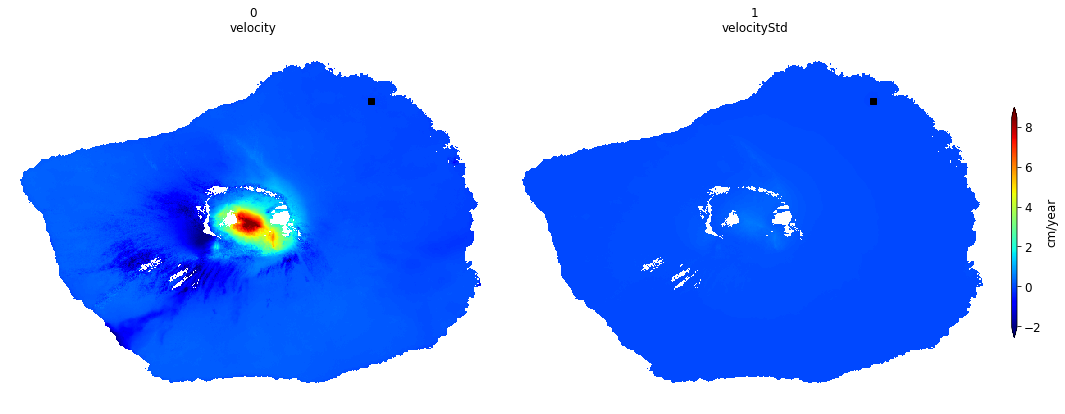

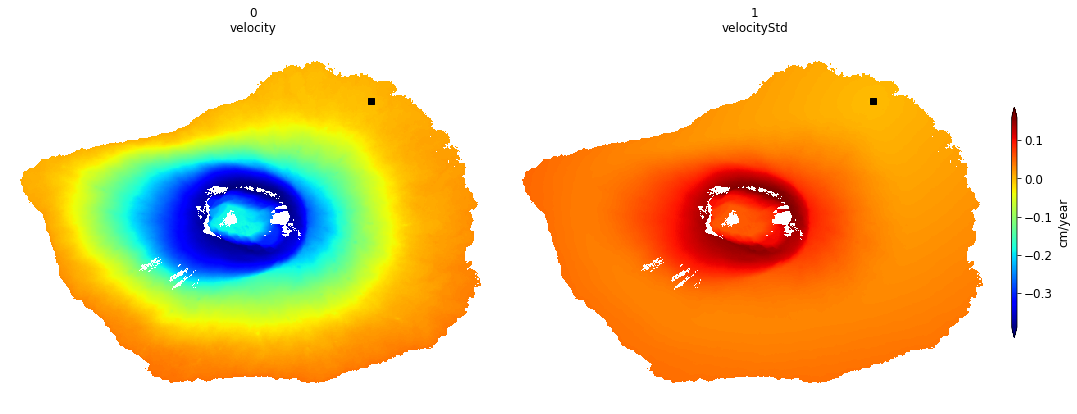

In [35]:
view.main('velocity.h5 --notick --noaxis --noverbose'.split())
view.main('velocityERA5.h5 --notick --noaxis --noverbose'.split())

### 2.14 Geocoding (optional) ###

This step resamples the following files from radar coordinates to geo coordinates. It's skipped if input dataset is in geo coordiantes already. The corresponding template options are:

```cfg
mintpy.geocode              = auto  #[yes / no], auto for yes
mintpy.geocode.SNWE         = auto  #[-1.2,0.5,-92,-91 / no ], auto for no, coverage in S N W E in degree
mintpy.geocode.latStep      = auto  #[0.0-90.0 / None], auto for None (calculate from lookup file)
mintpy.geocode.lonStep      = auto  #[0.0-180.0 / None], auto for None (calculate from lookup file)
mintpy.geocode.interpMethod = auto  #[nearest], auto for nearest, interpolation method
mintpy.geocode.fillValue    = auto  #[np.nan, 0, ...], auto for np.nan, fill value for outliers.
```

It outputs the following files into **./geo** folder:
+ ./geo/geo_geometryRadar.h5
+ ./geo/geo_maskTempCoh.h5
+ ./geo/geo_temporalCoherence.h5
+ ./geo/geo_timeseries_ECMWF_ramp_demErr.h5
+ ./geo/geo_velocity.h5

In [36]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep geocode

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:35:06.309060--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.cfg
read default template file: /home/jovyan/nisar-on-demand-use-case

In [37]:
!ls -l ./geo

total 114528
-rw-r--r-- 1 jovyan users   1109992 Feb 24 19:35 geo_avgSpatialCoh.h5
-rw-r--r-- 1 jovyan users   3253331 Feb 24 19:35 geo_geometryRadar.h5
-rw-r--r-- 1 jovyan users    290352 Feb 24 19:35 geo_maskTempCoh.h5
-rw-r--r-- 1 jovyan users   1111168 Feb 24 19:35 geo_temporalCoherence.h5
-rw-r--r-- 1 jovyan users 109292224 Feb 24 19:35 geo_timeseries_ERA5_ramp_demErr.h5
-rw-r--r-- 1 jovyan users   2209424 Feb 24 19:35 geo_velocity.h5


run view.py in MintPy release version v1.2.3-88, release date 2020-12-01
input file is velocity file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/geo/geo_velocity.h5 in float32 format
file size in y/x: (450, 600)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file geo_velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: (-91.70539145875654, -0.20357480635223515, -91.33854622434893, -0.5497810245555865)
subset coverage in lat/lon: (-91.70539145875654, -0.20357480635223515, -91.33854622434893, -0.5497810245555865)
------------------------------------------------------------------------
colormap: jet
figure title: geo_velocity
read mask from file: geo_maskTempCoh.h5
reading data ...
masking data
data    range: [-3.2468135, 9.477517] cm/year
displa

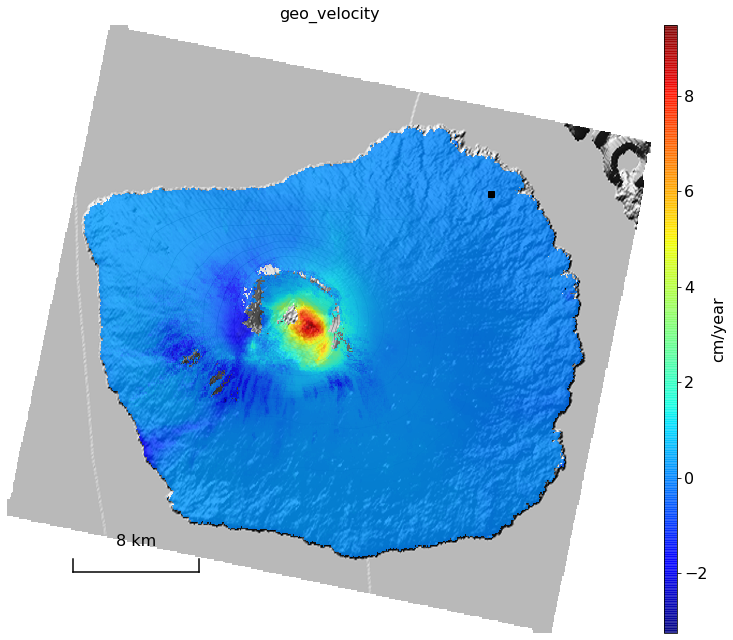

In [38]:
view.main('./geo/geo_velocity.h5 velocity --dem ./geo/geo_geometryRadar.h5 --figsize 12 12 --notick --noaxis'.split())

### 2.15 Output to Google Earth format (optional)

This step saves the geocoded velocity to the .kmz format. The corresponding template option is:  

```cfg
mintpy.save.kmz             = auto   #[yes / no], auto for yes, save geocoded velocity to Google Earth KMZ file
```

It output the ./geo/geo_velocity.kmz file.

In [39]:
!smallbaselineApp.py FernandinaSenDT128.txt --dostep google_earth

MintPy release version v1.2.3-88, release date 2020-12-01
--RUN-at-2021-02-24 19:35:24.241888--
Current directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy
read custom template file: /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/nisar-on-demand-use-cases/notebook_output/smallbaselineApp/data/test/FernandinaSenDT128/mintpy/smallbaselineApp.cfg
read default template file: /home/jovyan/nisar-on-demand-use-cases/notebook_

This step isn't available.

!open ./geo/geo_velocity.kmz   #Open KMZ file in Google Earth, which needs to be installed.

### 2.16 Save to HDF-EOS5 format (optional)

This step saves the geocoded displacement time-series into [HDF-EOS5](https://earthdata.nasa.gov/user-resources/standards-and-references/hdf-eos5) format. It is well-suited for **data sharing**. This format is used in University of Miami's insarmaps website: https://insarmaps.miami.edu.

The corresponding template options are:

```cfg
mintpy.save.hdfEos5         = auto   #[yes / no], auto for no, save time-series to HDF-EOS5 format
mintpy.save.hdfEs5.update   = auto   #[yes / no], auto for no, put XXXXXXXX as endDate in output filename
mintpy.save.hdfEos5.subset  = auto   #[yes / no], auto for no, put subset range info   in output filename
```

The output file includes 3D displacement time-series, temporal coherence, temporal coherence mask and all geometry related dataset: height, incidenceAngle, slantRangeDistance etc. For details on the naming convention and dataset structure, check the wiki page [here](https://github.com/insarlab/MintPy/wiki/HDF-EOS5). For this example dataset, it would output a file: S1_IW12_128_0593_0597_20141213_20180619.he5 if turn on. However, it's turn off and skipped here.

## 3. smallbaselineApp.py non-stop processing

Once the user gets familiar with the template setting, one can setup all the custom modified configurations (in the custom template file - recommeded), and run smallbaselineApp.py with a single command-line call to process all steps:

```
smallbaselineApp.py FernandinaSenDT128.txt
```

### 3.1 Re-run and skipping of processing steps

To facilitate the re-running process, a skipping strategy is implemented for all steps in smallbaselineApp.py and skip steps if:

1. output files / datasets already exist and are newer than input files / datasets 
2. AND for key / time-consuming steps (unwrap error correction, network inversion, topographic residual correction, etc.):     
    all related configurations are the same as before.

Therefore, one can modified the template option and re-run smallbaselineApp.py without specifying the start/end step, and the processing will start from where is changed and continue from there.

### 3.2 Move ./inputs after runing `smallbaselineApp.py --end load_data`

**./inputs** folder contains everything smallbaselineApp.py needs. One can move the ./inputs folder to anywhere MintPy is installed and re-start the whole analysis. It's well-suited for users who want to play around the analysis on their local laptop after the massive InSAR stack processing on the High Performance Computer (HPC) or Cloud.

## Relevant references:

+ Berardino, P., G. Fornaro, R. Lanari, and E. Sansosti (2002), A new algorithm for surface deformation monitoring based on small baseline differential SAR interferograms, Geoscience and Remote Sensing, IEEE Transactions on, 40(11), 2375-2383, doi:10.1109/TGRS.2002.803792.

+ Chaussard, E., F. Amelung, and Y. Aoki (2013), Characterization of open and closed volcanic systems in Indonesia and Mexico using InSAR time series, Journal of Geophysical Research: Solid Earth, 118(8), 3957-3969, doi:10.1002/jgrb.50288.

+ Chen, C. W., and H. A. Zebker (2001), Two-dimensional phase unwrapping with use of statistical models for cost functions in nonlinear optimization, JOSA A, 18(2), 338-351, doi:10.1364/JOSAA.18.000338.

+ Doin, M. P., C. Lasserre, G. Peltzer, O. Cavalié, and C. Doubre (2009), Corrections of stratified tropospheric delays in SAR interferometry: Validation with global atmospheric models, Journal of Applied Geophysics, 69(1), 35-50, doi:10.1016/j.jappgeo.2009.03.010.

+ Fattahi, H., and F. Amelung (2013), DEM Error Correction in InSAR Time Series, Geoscience and Remote Sensing, IEEE Transactions on, 51(7), 4249-4259, doi:10.1109/TGRS.2012.2227761.

+ Fattahi, H., and F. Amelung (2015), InSAR bias and uncertainty due to the systematic and stochastic tropospheric delay, Journal of Geophysical Research: Solid Earth, 120(12), 8758-8773, doi:10.1002/2015JB012419.

+ Fattahi, H., P. Agram, and M. Simons (2016), A Network-Based Enhanced Spectral Diversity Approach for TOPS Time-Series Analysis, IEEE Transactions on Geoscience and Remote Sensing, 55(2), 777-786, doi:10.1109/TGRS.2016.2614925.

+ Jolivet, R., R. Grandin, C. Lasserre, M. P. Doin, and G. Peltzer (2011), Systematic InSAR tropospheric phase delay corrections from global meteorological reanalysis data, Geophysical Research Letters, 38(17), L17311, doi:10.1029/2011GL048757.

+ Marinkovic, P., and Y. Larsen (2013), Consequences of long-term ASAR local oscillator frequency decay - An empirical study of 10 years of data, paper presented at Proceedings of the Living Planet Symposium (abstract), European Space Agency, Edinburgh, U. K.

+ Morales Rivera, A. M., F. Amelung, and P. Mothes (2016), Volcano Deformation Survey over the Northern and Central Andes with ALOS InSAR Time Series, Geochemistry, Geophysics, Geosystems, 17, 2869-2883, doi:10.1002/2016GC006393.

+ Pepe, A., and R. Lanari (2006), On the extension of the minimum cost flow algorithm for phase unwrapping of multitemporal differential SAR interferograms, Geoscience and Remote Sensing, IEEE Transactions on, 44(9), 2374-2383, doi:10.1109/TGRS.2006.873207.

+ Rosen, P. A., S. Hensley, G. Peltzer, and M. Simons (2004), Updated repeat orbit interferometry package released, Eos Trans. AGU, 85(5), 47-47, doi:10.1029/2004EO050004.

+ Rosen, P. A., E. Gurrola, G. F. Sacco, and H. Zebker (2012), The InSAR scientific computing environment, paper presented at EUSAR 2012, 23-26 April 2012.

+ Werner, C., U. Wegmüller, T. Strozzi, and A. Wiesmann (2000), Gamma SAR and interferometric processing software, paper presented at Proceedings of the ERS-Envisat symposium, Gothenburg, Sweden.

+ Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331, doi:10.1016/j.cageo.2019.104331.

+ Zebker, H. A., P. A. Rosen, and S. Hensley (1997), Atmospheric effects in interferometric synthetic aperture radar surface deformation and topographic maps, Journal of Geophysical Research: Solid Earth, 102(B4), 7547-7563, doi:10.1029/96JB03804.

<font size="1">This notebook is compatible with NISAR Jupyter Server Stack v1.4 and above</font>